dict_items([('D(8)', D(8)), ('C(4)', C(4)), ('C(2)', C(2))])


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

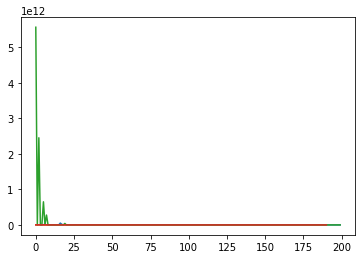

In [61]:
import emlp
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import objax
import torch
from emlp.datasets import Inertia
from emlp.groups import C, D
from emlp.reps import Scalar, T, Vector
from jax import vmap
from scipy.ndimage import rotate
# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm



MNIST_TRAIN_SIZE = 60000
MNIST_TEST_SIZE = 10000
SKLEARN_DIGITS_TRAIN_SIZE = 1247
SKLEARN_DIGITS_TEST_SIZE = 550


def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#


def train_emlp(G, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384, batch_size=500, lr=3e-3, num_epochs=5):

    rep_in = 28 * Scalar
    rep_out = 1 * Scalar
    model = emlp.nn.EMLP(rep_in, rep_out, group=G, num_layers=num_layers, ch=channels)
  
    opt = objax.optimizer.Adam(model.vars())
        
    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return ((yhat-y)**2).mean()

    grad_and_val = objax.GradValues(loss, model.vars())

    
    @objax.Jit
    @objax.Function.with_vars(model.vars()+opt.vars())
    def train_op(x, y, lr):
        g, v = grad_and_val(x, y)
        opt(lr=lr, grads=g)
        return v

  
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        train_losses.append(np.mean([train_op(jnp.array(x), jnp.array(y),lr) for (x,y) in train]))
        if not epoch % 10:
            test_losses.append(np.mean([loss(jnp.array(x), jnp.array(y)) for (x,y) in test]))
  
    #print(f"Average test equivariance error {np.mean([equivariance_err(G, train, mb) for mb in testloader]):.2e}")
    return train_losses, test_losses

def equivariance_err(G, train, mb):
    rin,rout = train.rep_in(G),train.rep_out(G)
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

def compare_groups(grps, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384, batch_size=5, lr=3e-3, num_epochs=5):
    for name, G in grps.items():
        train_losses, test_losses = train_emlp(G, train, test, num_layers, channels, batch_size, lr, num_epochs)
        plt.plot(np.arange(num_epochs), train_losses, label=name + ' train loss')
        plt.plot(np.arange(0, num_epochs, 10), test_losses, label=name+' test loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

    
def get_sklearn_digits_dataset(loader):
    """Downloads Sklearn handwritten digits dataset.
    Uses the last SKLEARN_DIGITS_TEST_SIZE examples as the test
    This is (hard-coded) -- do not change.
    Parameters
    ----------
    loader : str (values: 'train' or 'test')."""
    from sklearn.datasets import load_digits
    from torch.utils.data import Dataset

    class TorchDataset(Dataset):
        """Abstracts a numpy array as a PyTorch dataset."""

        def __init__(self, data, targets, transform=None):
            self.data = torch.from_numpy(data).float()
            self.targets = torch.from_numpy(targets).long()
            self.transform = transform

        def __getitem__(self, index):
            x = self.data[index]
            y = self.targets[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.data)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    # Get sklearn digits dataset
    X_all, y_all = load_digits(return_X_y=True)
    X_all = X_all.reshape((len(X_all), 8, 8))
    y_train = y_all[:-SKLEARN_DIGITS_TEST_SIZE]
    y_test = y_all[-SKLEARN_DIGITS_TEST_SIZE:]
    X_train = X_all[:-SKLEARN_DIGITS_TEST_SIZE]
    X_test = X_all[-SKLEARN_DIGITS_TEST_SIZE:]
    if loader == 'train':
        return  TorchDataset(X_train, y_train, transform=transform)
    elif loader == 'test':
        return TorchDataset(X_test, y_test, transform=transform)
    else:  # prama: no cover
        raise ValueError("loader must be either str 'train' or str 'test'.")
    


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../mnist_data', 
                download=False, 
                train=True,
                transform=transforms.Compose([
                    transforms.ToTensor(), # first, convert image to PyTorch tensor
                    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                ])), 
            batch_size=10, 
            shuffle=True
        )

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../mnist_data', 
                download=False, 
                train=False,
                transform=transforms.Compose([
                    transforms.ToTensor(), # first, convert image to PyTorch tensor
                    transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                ])), 
            batch_size=10, 
            shuffle=True
        )
d8 = D(8)
c4 = C(4)
c2 = C(2)
groups = {
    'D(8)': d8,
    "C(4)": c4,
    "C(2)":c2
}
print(groups.items())

compare_groups(groups, train=train_loader, test=test_loader, num_epochs=200)


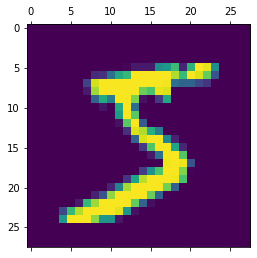

In [11]:
mnist_train = datasets.MNIST(
    '../mnist_data', 
    download=False, 
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # first, convert image to PyTorch tensor
        transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
        ]
    )
)
plt.matshow(mnist_train.data[0])


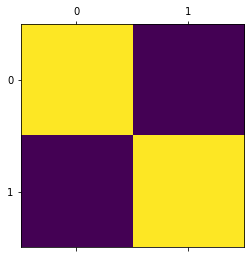

In [23]:
p = c4.sample().copy()
q = p.T
#plt.matshow( mnist_train.data[0].numpy())
plt.matshow(p)

In [24]:
dir(c4)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'args',
 'check_valid_group_elems',
 'd',
 'discrete_generators',
 'exp',
 'is_orthogonal',
 'is_regular',
 'lie_algebra',
 'num_constraints',
 'sample',
 'samples',
 'z_scale']

In [27]:
c4.discrete_generators

DeviceArray([[[ 6.123234e-17,  1.000000e+00],
              [-1.000000e+00,  6.123234e-17]]], dtype=float32)

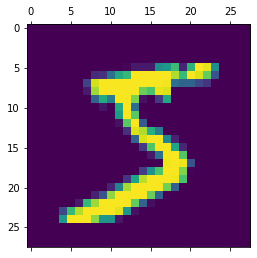

In [59]:
repin = 28 * Scalar
repout = 1 * Scalar
Q = (repin(c2)>>repout(c2)).equivariant_basis()
plt.matshow(Q * mnist_train.data[0].numpy())

In [51]:
from emlp.reps import V,T
from emlp.groups import *

repin = 28 * Scalar
repout = 1 * Scalar
Q = (repin(d8)>>repout(d8)).equivariant_basis()
Q = (T(1,0)>>T(2,1))(c2).equivariant_basis()
Q = Q.copy()
print(dir(Q))
print(Q.shape)
plt.matshow( Q * mnist_train.data[0].numpy())

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift_

ValueError: operands could not be broadcast together with shapes (16,16) (28,28) 